# Battle of Neighborhoods - Kitchen Supply Store

## 1. Business Problem 

There are many food venues (restaurants, food courts, coffee shops, food trucks) in Penang, Malaysia. To open a Food & Beverage (F&B) shop in Penang means that you have to face fierce competition from these food and drinks providers. Instead of compete with them, you can work with them by opening a shop to supply one or more of the following:
- Kitchen utensils (knife, cooking pots, cooking pans, etc.) 
- Dining supplies (plates, bowls, glasses, spoons, etc.)
- Raw materials (beef, pork, chicken meat, vegetables, etc.)

The location of the kitchen supply store will decide if the store will success by getting enough customers with less or no competitors.

This study excludes the raw materials supply.

### Objective: 
To analyse and select the best location in the Penang, Malaysia to open a new kitchen supply store.

### Business Questions
In Penang, if a business owner is looking to open a new kitchen supply store,
- Where would you recommend them to open it?  


### Target Audience 
Business owners who are looking to open a new kitchen supply store in Penang.


----------------

## 2. Data

### Data Required 

- A list of neighbourhoods in Penang 
- Latitude and longitude coordinates of the neighbourhoods
- Food venues data - category type, latitude and longitude coordinates
- A list shops that also provide kitchen supplies (kitchen supply stores, supermarkets) and their latitude and longitude coordinates. These shops are our competitors. 

### Source of Data 

- Wikipedia page for Penang neighbourhoods
(https://en.wikipedia.org/wiki/Category:Districts_of_Penang)
- Geocoder package to find out the latitude and longitude coordinates.
- Foursquare API for venue data.
- Google Search and Google Map to find out the latitude and longitude coordinate for kitchen supply stores that are not given by Foursquare API. 

-------------------

## 3. Methodology

1. Converting the neighbourhoods of Penang in Wikipedia html into a DataFrame
2. Find out the latitude and longitude of the neighbourhoods and plot them on Penang map
3. Use the Foursquare API to get the food venues (our customers) and kitchen supply stores (our competitor).
4. Add additional kitchen supply stores that are not provided by Foursquare API to the list. Find out their latitude and longitude, category and neighbourhood.
5. Get the average food venues served by one competitor per neighbourhood. 
7. Propose a location to open a kitchen supply store based on the analysis.

---------------------

## 4. Data Acquisition and Cleaning

### Import Libraries ###

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


### Converting Neighbourhoods in Wikipedia html into a DataFrame

In [2]:
# send the GET request
data = requests.get("https://en.wikipedia.org/wiki/Category:Districts_of_Penang").text

In [3]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [4]:
# create a list to store neighborhood data
neighborhoodList = []

In [5]:
# find all hyperlink tag <a>
tags = soup.find_all('a')

# append the data into the list
for t in tags:
    neighborhoodList.append(t.text)
    

In [6]:
# create a new DataFrame from the list
pg_df = pd.DataFrame({"Neighborhood": neighborhoodList})
pg_df

,Neighborhood
0,
1,Help
2,Jump to navigation
3,Jump to search
4,v
5,t
6,e
7,State
8,Penang
9,George Town


The Suburbs and towns are from index 43 to 65. Assign them to a new dataframe

In [7]:
# drop by position, drop from 66 to 198
pg_df = pg_df.drop(pg_df.index[66:199])

# drop by position, drop from 0 to 42
pg_df = pg_df.drop(pg_df.index[0:43])

pg_df

,Neighborhood
43,Air Itam
44,Balik Pulau
45,Batu Ferringhi
46,Batu Kawan
47,Batu Lanchang
48,Bayan Lepas
49,Bukit Mertajam
50,Butterworth
51,Gelugor
52,Jelutong


In [8]:
# George town and Bayan Baru are added - well developed areas with many restaurants
pg_df = pg_df.append({'Neighborhood' : 'George Town'} , ignore_index=True)
pg_df = pg_df.append({'Neighborhood' : 'Bayan Baru'} , ignore_index=True)
pg_df.sort_values(by=['Neighborhood'], inplace=True)

In [9]:
# reset index, the 'drop; is to delete old index column
pg_df = pg_df.reset_index(drop = True)
pg_df

,Neighborhood
0,Air Itam
1,Balik Pulau
2,Batu Ferringhi
3,Batu Kawan
4,Batu Lanchang
5,Bayan Baru
6,Bayan Lepas
7,Bukit Mertajam
8,Butterworth
9,Gelugor


In [10]:
# print the number of rows of the dataframe
pg_df.shape

(25, 1)

### Get the Geographical Coordinates of the Neighbourhoods

In [11]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    location = None
    # loop until you get the coordinates
    while(location is None):
        geolocator = Nominatim(user_agent="pg_explorer")
        g = geolocator.geocode('{}, Penang, Malaysia'.format(neighborhood))
        location = (g.latitude, g.longitude)
    return location

In [15]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in pg_df["Neighborhood"].tolist() ]
coords

[(5.4018648, 100.2778327),
 (5.3482059, 100.2274047),
 (5.4682573, 100.2503291),
 (5.2625962, 100.4304555),
 (5.3833333, 100.3),
 (5.3228416, 100.2890394),
 (5.2953847, 100.2857548),
 (5.3663396, 100.447698029297),
 (5.3935211, 100.366264819942),
 (5.3675141, 100.3121321),
 (5.4145681, 100.3298035),
 (5.3869071, 100.3120903),
 (5.5146783, 100.4284639),
 (5.1700963, 100.4785191),
 (5.3718034, 100.276162),
 (5.3777664, 100.3819635),
 (5.4104982, 100.4136507),
 (5.4318216, 100.3117683),
 (5.2817072, 100.4765976),
 (5.2511123, 100.4520518),
 (5.4574693, 100.2870022),
 (5.4461393, 100.3052541),
 (5.4832292, 100.4904761),
 (5.457804, 100.2147715),
 (5.2897572, 100.23151)]

In [16]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [17]:
# merge the coordinates into the pg_df
pg_df['Latitude'] = df_coords['Latitude']
pg_df['Longitude'] = df_coords['Longitude']

In [18]:
# check the neighborhoods and the coordinates
print(pg_df.shape)
pg_df

(25, 3)


,Neighborhood,Latitude,Longitude
0,Air Itam,5.401865,100.277833
1,Balik Pulau,5.348206,100.227405
2,Batu Ferringhi,5.468257,100.250329
3,Batu Kawan,5.262596,100.430455
4,Batu Lanchang,5.383333,100.300000
5,Bayan Baru,5.322842,100.289039
6,Bayan Lepas,5.295385,100.285755
7,Bukit Mertajam,5.366340,100.447698
8,Butterworth,5.393521,100.366265
9,Gelugor,5.367514,100.312132


In [19]:
# save the DataFrame as CSV file
pg_df.to_csv("pg_df.csv", index=False)

In [ ]:
# In case geolocator.geocode fail, read from CSV file
# pg_df  = pd.read_csv('pg_df.csv')

### Superimpose Neighborhoods on Top of Penang Map

In [20]:
# get the coordinates of Penang
address = 'Penang, Malaysia'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Penang, Malaysia {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Penang, Malaysia 5.4065013, 100.2559077.


In [21]:
# create map of Penang using latitude and longitude values
map_pg = folium.Map(location=[latitude, longitude], zoom_start=11, height=800)

# add markers to map
for lat, lng, neighborhood in zip(pg_df['Latitude'], pg_df['Longitude'], pg_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_pg)  
    
map_pg

In [22]:
# save the map as HTML file
map_pg.save('map_pg.html')

### Use Foursquare API to get the Food Venues for each Neighborhood

In [23]:
# define Foursquare Credentials and Version
CLIENT_ID = 'AM3OMA5MJOA0PT5MVT4YV0X5EGHFJL03BQM1VH3IFHAVMFT0' # your Foursquare ID
CLIENT_SECRET = 'IIOEDPGXO5GDIGJ5EYRJSKZW0FGLGTPAKQYZ52AYVBHAWZPB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AM3OMA5MJOA0PT5MVT4YV0X5EGHFJL03BQM1VH3IFHAVMFT0
CLIENT_SECRET:IIOEDPGXO5GDIGJ5EYRJSKZW0FGLGTPAKQYZ52AYVBHAWZPB


Get Top 100 food venues that are within a radius of 1000 meters for each neighbourhood

In [24]:
radius = 1000  # 1km radius from the center of each neighbourhood
LIMIT = 100    # limit the number of return records 
categoryID = "4d4b7105d754a06374d81259"    # food venue category

FOURSQUARE_SEARCH_URL = 'https://api.foursquare.com/v2/venues/search?'
# SEARCH VENUES BY CATEGORY
LIMIT = 200

# Dataframe : venue_id_recover 
# - store venue id to recover failed venues id score retrieval later if foursquare limit is exceeded when getting score.
venue_id_rcols = ['VenueID']
venue_id_recover = pd.DataFrame(columns=venue_id_rcols)

def getVenuesByCategory(names, latitudes, longitudes, categoryID, radius=1000):
    global CLIENT_ID
    global CLIENT_SECRET
    global FOURSQUARE_EXPLORE_URL
    global FOURSQUARE_SEARCH_URL
    global VERSION
    global LIMIT
    venue_columns = ['Neighborhood','Latitude','Longitude','VenueID','VenueName','VenueLatitude', 'VenueLongitude', 'VenueCategory']
    venue_DF = pd.DataFrame(columns=venue_columns)
    print("[#Start getVenuesByCategory]")
    for name, lat, lng in zip(names, latitudes, longitudes):
        #cyclefsk2()
        print(name,",",end='')
        #print('getVenuesByCategory',categoryID,name) ; # DEBUG: be quiet
        # create the API request URL
        url = '{}client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            FOURSQUARE_SEARCH_URL,CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT,categoryID)
        # make the GET request
        results = requests.get(url).json()
        # Populate dataframe with the category venue results
        # Extracting JSON  data values
        
        for jsonSub in results['response']['venues']:
            #print(jsonSub)
            # JSON Results may not be in expected format or incomplete data, in that case, skip!
            ven_id = 0
            try:
                # If there are any issue with a restaurant, retry or ignore and continue
                # Get location details
                ven_id   = jsonSub['id']
                ven_cat  = jsonSub['categories'][0]['pluralName']
                ven_CID  = jsonSub['categories'][0]['id']
                ven_name = jsonSub['name']
                ven_lat  = jsonSub['location']['lat']
                ven_lng  = jsonSub['location']['lng']
                venue_DF = venue_DF.append({
                    'Neighborhood'      : name,
                    'Latitude' : lat,
                    'Longitude': lng,
                    'VenueID'   : ven_id,
                    'VenueName' : ven_name,
                    'VenueLatitude': ven_lat,
                    'VenueLongitude': ven_lng,
                    'VenueCategory': ven_cat}, 
                    ignore_index=True)
            except:
                continue
    # END OF LOOP, return.
    print("\n[#Done getVenuesByCategory]")
    return(venue_DF)

In [25]:
# Food Venues : Restaurants, Food Courts, Etc
# https://developer.foursquare.com/docs/resources/categories
categoryID = "4d4b7105d754a06374d81259"    # food category
neighborhood_names = pg_df['Neighborhood']
lat_list   = pg_df['Latitude']
lng_list   = pg_df['Longitude']
foodVenues_df = getVenuesByCategory(names=neighborhood_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)
foodVenues_df.head(10)

[#Start getVenuesByCategory]
Air Itam ,Balik Pulau ,Batu Ferringhi ,Batu Kawan ,Batu Lanchang ,Bayan Baru ,Bayan Lepas ,Bukit Mertajam ,Butterworth ,Gelugor ,George Town ,Jelutong ,Kepala Batas ,Nibong Tebal ,Paya Terubong ,Perai ,Permatang Pauh ,Pulau Tikus ,Simpang Ampat ,Sungai Jawi ,Tanjung Bungah ,Tanjung Tokong ,Tasek Gelugor ,Teluk Bahang ,Teluk Kumbar ,
[#Done getVenuesByCategory]


,Neighborhood,Latitude,Longitude,VenueID,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Air Itam,5.401865,100.277833,4d19d3966c8b5481c953fbcc,Air Itam Asam Laksa,5.401591,100.278277,Food Stands
1,Air Itam,5.401865,100.277833,4d4814f611618cfaba90d023,Air Itam Market Annex Food Court,5.401456,100.278058,Food Courts
2,Air Itam,5.401865,100.277833,4ce9f988948f224b6442f95d,Sin Ka Oon Bakery 新加恩,5.401650,100.278303,Bakeries
3,Air Itam,5.401865,100.277833,4dc49b4a7d8b14fb4615eba3,Kopitiam Bawah Pokok,5.401579,100.277494,Coffee Shops
4,Air Itam,5.401865,100.277833,4c950b8772dd224b8ee29f91,Air Itam Duck Rice (亞依淡鴨飯),5.401482,100.277989,Food Stands
5,Air Itam,5.401865,100.277833,56c15570cd10904e6ae336fb,新荣华饮食中心 Sin Yong Wah Coffee Shop (Kedai Kopi S...,5.401409,100.277522,Coffee Shops
6,Air Itam,5.401865,100.277833,4bbfbc862a89ef3bd57cef88,Wah Meng Cafe (華茗餐室),5.400214,100.278005,Coffee Shops
7,Air Itam,5.401865,100.277833,5916f6b01987ec2534b80cc7,Seven Ocean Seafood Cafe,5.401790,100.276463,Chinese Restaurants
8,Air Itam,5.401865,100.277833,4e5b0210483b865169f409b7,Hakka Noodle 客家面,5.401813,100.276711,Noodle Houses
9,Air Itam,5.401865,100.277833,4d55df8ecc65a143993c545e,Sister's Curry Mee (暹罗姐妹咖喱面),5.400410,100.278934,Noodle Houses


In [26]:
# Save the data
foodVenues_df.to_csv('foodVenues_df.csv')

### Clean the Food Venue Data

Check if the categories returned are correct.

In [27]:
# print out the list of categories
foodVenues_df['VenueCategory'].unique()

array(['Food Stands', 'Food Courts', 'Bakeries', 'Coffee Shops',
       'Chinese Restaurants', 'Noodle Houses', 'Comfort Food Restaurants',
       'Seafood Restaurants', 'American Restaurants', 'Asian Restaurants',
       'Cafés', 'Restaurants', 'Food', 'Food Trucks', 'Thai Restaurants',
       'Dim Sum Restaurants', 'Burger Joints', 'Indian Restaurants',
       'Halal Restaurants', 'Dessert Shops', 'Malay Restaurants',
       'Indonesian Restaurants', 'Mediterranean Restaurants',
       'Afghan Restaurants', 'Dumpling Restaurants',
       'Chinese Breakfast Places', 'Snack Places', 'Juice Bars',
       'Fast Food Restaurants', 'Sandwich Places',
       'Middle Eastern Restaurants', 'Steakhouses', 'Bars',
       'Pizza Places', 'Southern / Soul Food Restaurants', 'Bistros',
       'Diners', 'Eastern European Restaurants', 'Pakistani Restaurants',
       'Italian Restaurants', 'Hainan Restaurants', 'Breakfast Spots',
       'Tea Rooms', 'Vegetarian / Vegan Restaurants',
       'Street F

Show the venue data in the categories that is not confirmed correct.

In [28]:
ambiguous_category = ['Flea Markets',
'Food Services'
'Parks',
'Farmers Markets',
'Hotels',
'Delis / Bodegas'
'Pet Services',
'Government Buildings',
'Fish Markets',
'Wings Joints',
'Markets']
foodVenues_df[foodVenues_df['VenueCategory'].isin(ambiguous_category)]

,Neighborhood,Latitude,Longitude,VenueID,VenueName,VenueLatitude,VenueLongitude,VenueCategory
206,Batu Lanchang,5.383333,100.300000,5ca9f8128c35dc002c7b2add,Chicken Joint,5.383983,100.307920,Wings Joints
263,Bayan Baru,5.322842,100.289039,4d2ae4ea6e27a1439f723224,Bukit Gedung Night Flea Market (Pasar Malam),5.316848,100.283469,Flea Markets
264,Bayan Baru,5.322842,100.289039,4d53ce53f5daa093b7866a74,Bayan Baru Night Flea Market (Pasar Malam),5.329640,100.290970,Flea Markets
526,George Town,5.414568,100.329803,4badacd3f964a52088623be3,Sunway Hotel,5.414179,100.326030,Hotels
531,Jelutong,5.386907,100.312090,4b75763af964a520dc0d2ee3,Jelutong Morning Market,5.389872,100.312173,Farmers Markets
582,Kepala Batas,5.514678,100.428464,4e14599962e14518a9246739,Kepala Batas Night Flea Market (Pasar Malam),5.517392,100.426506,Flea Markets
724,Perai,5.377766,100.381963,4ecc9594b6344934dcd962de,Pejabat FAMA Negeri Pulau Pinang,5.378677,100.384934,Government Buildings
825,Pulau Tikus,5.431822,100.311768,4c6605308e9120a1051ed764,Pulau Tikus Market,5.430481,100.311924,Markets
941,Tanjung Bungah,5.457469,100.287002,4bdcdcf1462b2d7f58b5113c,Tanjung Bungah Market,5.464054,100.284948,Markets
1078,Teluk Bahang,5.457804,100.214771,4d9f93de53af236a9c8b730c,Pasar Awam Teluk Bahang (Market),5.457381,100.213611,Fish Markets


Flea markets are night markets in neighbourhood. There are stalls that serve foods and drinks.    
Cubo Park - many shops that serve late night desserts.  

Venues that are not related to foods and drinks, will be deleted:
- Sunway Hotel
- Pejabat FAMA Negeri Pulau Pinang
- Pasar Awam Teluk Bahang (Market)
- Tanjung Bungah Market
- Pulau Tikus Market
- Jelutong Morning Market


In [29]:
# drop venues by index
foodVenues_df = foodVenues_df.drop([526, 531, 724, 825, 941, 1078])

# confirm the venues have been deleted
foodVenues_df[foodVenues_df['VenueCategory'].isin(ambiguous_category)]


,Neighborhood,Latitude,Longitude,VenueID,VenueName,VenueLatitude,VenueLongitude,VenueCategory
206,Batu Lanchang,5.383333,100.300000,5ca9f8128c35dc002c7b2add,Chicken Joint,5.383983,100.307920,Wings Joints
263,Bayan Baru,5.322842,100.289039,4d2ae4ea6e27a1439f723224,Bukit Gedung Night Flea Market (Pasar Malam),5.316848,100.283469,Flea Markets
264,Bayan Baru,5.322842,100.289039,4d53ce53f5daa093b7866a74,Bayan Baru Night Flea Market (Pasar Malam),5.329640,100.290970,Flea Markets
582,Kepala Batas,5.514678,100.428464,4e14599962e14518a9246739,Kepala Batas Night Flea Market (Pasar Malam),5.517392,100.426506,Flea Markets


Fast food restaurants have their own supply chain. The shops are removed.

In [30]:
# delete all rows for which column 'VenueCategory' is 'Fast Food Restaurants'
indexNames = foodVenues_df[ (foodVenues_df['VenueCategory'] == 'Fast Food Restaurants')].index 
foodVenues_df.drop(indexNames , inplace=True)

# confirm the rows are removed.
foodVenues_df['VenueCategory'].unique()

array(['Food Stands', 'Food Courts', 'Bakeries', 'Coffee Shops',
       'Chinese Restaurants', 'Noodle Houses', 'Comfort Food Restaurants',
       'Seafood Restaurants', 'American Restaurants', 'Asian Restaurants',
       'Cafés', 'Restaurants', 'Food', 'Food Trucks', 'Thai Restaurants',
       'Dim Sum Restaurants', 'Burger Joints', 'Indian Restaurants',
       'Halal Restaurants', 'Dessert Shops', 'Malay Restaurants',
       'Indonesian Restaurants', 'Mediterranean Restaurants',
       'Afghan Restaurants', 'Dumpling Restaurants',
       'Chinese Breakfast Places', 'Snack Places', 'Juice Bars',
       'Sandwich Places', 'Middle Eastern Restaurants', 'Steakhouses',
       'Bars', 'Pizza Places', 'Southern / Soul Food Restaurants',
       'Bistros', 'Diners', 'Eastern European Restaurants',
       'Pakistani Restaurants', 'Italian Restaurants',
       'Hainan Restaurants', 'Breakfast Spots', 'Tea Rooms',
       'Vegetarian / Vegan Restaurants', 'Street Food Gatherings',
       'Wings J

In [31]:
foodVenues_df.shape

(1133, 8)

Drop duplicate venues with the same venue name, latitude and longitute and keep the first row which appear

In [32]:
foodVenues_df.drop_duplicates(['VenueName','VenueLatitude','VenueLongitude'],keep= 'first', inplace = True) 

In [33]:
foodVenues_df.shape

(1101, 8)

32 duplicate venues are deleted.

In [34]:
# save to CSV file
foodVenues_df.to_csv("foodVenues_df.csv")

In [ ]:
# In case Foursquare fail to supply the data, read from CSV file
# foodVenues_df  = pd.read_csv('foodVenues_df.csv')

### Show all the Food Venues on Penang Map

In [35]:
# create map of Penang using latitude and longitude values
map_pg_foodvenues = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, v_name in zip(foodVenues_df['VenueLatitude'], foodVenues_df['VenueLongitude'], foodVenues_df['VenueName']):
    label = '{}'.format(v_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5).add_to(map_pg_foodvenues)  

map_pg_foodvenues


### Data Analysis on Food Venues

Check how many venues were returned for each neighorhood

In [36]:
foodVenues_df.groupby(["Neighborhood"]).count()

,Latitude,Longitude,VenueID,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,,
Air Itam,50,50,50,50,50,50,50
Balik Pulau,48,48,48,48,48,48,48
Batu Ferringhi,48,48,48,48,48,48,48
Batu Kawan,29,29,29,29,29,29,29
Batu Lanchang,49,49,49,49,49,49,49
Bayan Baru,46,46,46,46,46,46,46
Bayan Lepas,50,50,50,50,50,50,50
Bukit Mertajam,49,49,49,49,49,49,49
Butterworth,47,47,47,47,47,47,47


###  Top 10 Food Venue Categories with the Highest Frequency

In [37]:
top10_foodvenue_category = foodVenues_df['VenueCategory'].value_counts()[0:10].to_frame(name='frequency')
top10_foodvenue_category.reset_index(inplace=True)
top10_foodvenue_category.rename(index=str, columns={"index": "FoodVenueCategory", "frequency": "Frequency"}, inplace=True)
top10_foodvenue_category

,FoodVenueCategory,Frequency
0,Malay Restaurants,118
1,Coffee Shops,106
2,Asian Restaurants,104
3,Cafés,81
4,Chinese Restaurants,65
5,Food Courts,49
6,Food Trucks,46
7,Seafood Restaurants,44
8,Indian Restaurants,37
9,Burger Joints,36


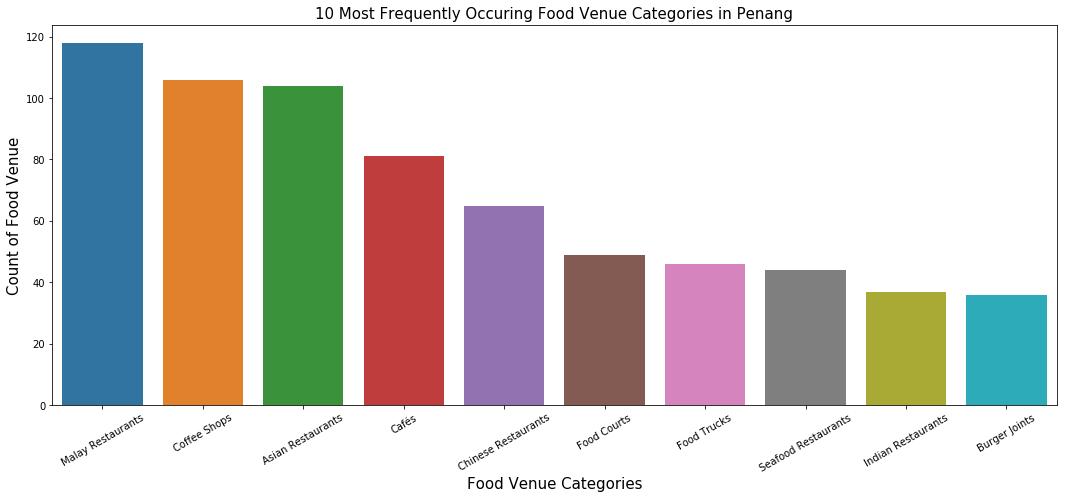

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="FoodVenueCategory", y="Frequency", data=top10_foodvenue_category)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Food Venue Categories in Penang', fontsize=15)
plt.xlabel("Food Venue Categories", fontsize=15)
plt.ylabel ("Count of Food Venue", fontsize=15)
plt.savefig("Most_Freq_FoodVenues.png", dpi=300)
plt.show()

Coffee shops are the most common food venues in Penang, followed by Malay restaurants and Chinese restaurants.

### Malay Restaurants Analysis

In [40]:
# Filter the Malay restaurants to malay_restaurant_df
malay_restaurant_df = foodVenues_df[foodVenues_df['VenueCategory'] == 'Malay Restaurants']
malay_restaurant_df.head(10)

,Neighborhood,Latitude,Longitude,VenueID,VenueName,VenueLatitude,VenueLongitude,VenueCategory
52,Balik Pulau,5.348206,100.227405,50ee0bc4e4b0eb13e2a08048,Roti Canai @ Pejabat Agama Daerah Barat Daya,5.349417,100.230894,Malay Restaurants
56,Balik Pulau,5.348206,100.227405,4cee4d20b1466a31606fa8fe,Azlan Tomyam,5.345825,100.229827,Malay Restaurants
68,Balik Pulau,5.348206,100.227405,4cfeee431ebe6dcbe1a37e91,Restoran Kalik,5.349492,100.233350,Malay Restaurants
74,Balik Pulau,5.348206,100.227405,4e05c26352b165b7d7a35e1b,Restoran Nasi Kandar Habeeb,5.350630,100.235068,Malay Restaurants
77,Balik Pulau,5.348206,100.227405,55867c7f498e7d009d7dfe89,Kedai Kak Mah,5.349243,100.232735,Malay Restaurants
84,Balik Pulau,5.348206,100.227405,51a000af498ea3d3d570b520,Warong Roti Canai Pak Ku Pejabat Agama,5.356333,100.227252,Malay Restaurants
86,Balik Pulau,5.348206,100.227405,5182ea7f498e2533326d72a6,Restoran Roundaboard,5.350637,100.234913,Malay Restaurants
92,Balik Pulau,5.348206,100.227405,5a8065e2cad1b66c53303dee,Aisyah Cafe,5.340795,100.229932,Malay Restaurants
94,Balik Pulau,5.348206,100.227405,50d53075e4b05909f40d4aca,Gerai makan bawah khemah,5.345293,100.235378,Malay Restaurants
98,Batu Ferringhi,5.468257,100.250329,4cb5b2711b0af04d45f2ca25,Ajid Cafe,5.470811,100.245713,Malay Restaurants


In [41]:
malay_restaurant_df['Neighborhood'].value_counts().to_frame(name='Count').head(10)

,Count
Teluk Bahang,16
Tasek Gelugor,11
Butterworth,10
Teluk Kumbar,10
Balik Pulau,9
Perai,8
Permatang Pauh,8
Gelugor,7
Kepala Batas,7
Bukit Mertajam,6


Teluk Bahang has the largest number of Malay restaurants, followed by Tasek Gelugor and Butterworth.

### Show Malay Restaurants on Penang Map

In [42]:
# Create map of Malay restaurants in Penang using latitude and longitude values
map_pg_malay_restaurants = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(malay_restaurant_df['VenueLatitude'], malay_restaurant_df['VenueLongitude'], malay_restaurant_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.5).add_to(map_pg_malay_restaurants)  
    
map_pg_malay_restaurants

In [43]:
# Save the map
map_pg_malay_restaurants.save('map_pg_malay_restaurants.html')

### Find out the Competitors

**Competitors:**
- Kitchen supply stores
- Supermarkets, hypermarkets and department stores
- Discount stores, like Mr DIY

The competitors excluded shops that build kitchen cabinets, large kitchen appliances and equipments.

**Kitchen Supply Stores**

In [65]:
# https://developer.foursquare.com/docs/resources/categories
categoryID = "58daa1558bbb0b01f18ec1b4"    # Kitchen Supply Store
neighborhood_names = pg_df['Neighborhood']
lat_list   = pg_df['Latitude']
lng_list   = pg_df['Longitude']
kitchen_supply_df = getVenuesByCategory(names=neighborhood_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)
kitchen_supply_df.head(10)

[#Start getVenuesByCategory]
Air Itam ,Balik Pulau ,Batu Ferringhi ,Batu Kawan ,Batu Lanchang ,Bayan Baru ,Bayan Lepas ,Bukit Mertajam ,Butterworth ,Gelugor ,George Town ,Jelutong ,Kepala Batas ,Nibong Tebal ,Paya Terubong ,Perai ,Permatang Pauh ,Pulau Tikus ,Simpang Ampat ,Sungai Jawi ,Tanjung Bungah ,Tanjung Tokong ,Tasek Gelugor ,Teluk Bahang ,Teluk Kumbar ,
[#Done getVenuesByCategory]


,Neighborhood,Latitude,Longitude,VenueID,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,George Town,5.414568,100.329803,59b5dfad66fc6523c3ea5c87,Ptpl Kitchen 1,5.414789,100.319187,Kitchen Supply Stores
1,George Town,5.414568,100.329803,59b5e0021499466c7a9628f8,Ptpl Kitchen 2,5.414759,100.319197,Kitchen Supply Stores
2,Permatang Pauh,5.410498,100.413651,53fabb3a498e7a693209438d,Win Wins Kitchen Equipments Sdn. Bhd.,5.409110,100.407841,Hardware Stores


MSU College (Formerly known as Pusat Teknologi dan Pengurusan Lanjutan, PTPL) is a private college in Malaysia. Will be removed.

In [66]:
kitchen_supply_df = kitchen_supply_df.drop([0, 1])
kitchen_supply_df

,Neighborhood,Latitude,Longitude,VenueID,VenueName,VenueLatitude,VenueLongitude,VenueCategory
2,Permatang Pauh,5.410498,100.413651,53fabb3a498e7a693209438d,Win Wins Kitchen Equipments Sdn. Bhd.,5.40911,100.407841,Hardware Stores


**Supermarket**

In [69]:
# https://developer.foursquare.com/docs/resources/categories
categoryID = "52f2ab2ebcbc57f1066b8b46"    # Supermarket
neighborhood_names = pg_df['Neighborhood']
lat_list   = pg_df['Latitude']
lng_list   = pg_df['Longitude']
supermarket_df = getVenuesByCategory(names=neighborhood_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)
supermarket_df

[#Start getVenuesByCategory]
Air Itam ,Balik Pulau ,Batu Ferringhi ,Batu Kawan ,Batu Lanchang ,Bayan Baru ,Bayan Lepas ,Bukit Mertajam ,Butterworth ,Gelugor ,George Town ,Jelutong ,Kepala Batas ,Nibong Tebal ,Paya Terubong ,Perai ,Permatang Pauh ,Pulau Tikus ,Simpang Ampat ,Sungai Jawi ,Tanjung Bungah ,Tanjung Tokong ,Tasek Gelugor ,Teluk Bahang ,Teluk Kumbar ,
[#Done getVenuesByCategory]


,Neighborhood,Latitude,Longitude,VenueID,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Balik Pulau,5.348206,100.227405,53e5ad14498e7c5b4fa1ca85,Ceria 99 - Balik Pulau,5.351872,100.235224,Department Stores
1,Bayan Baru,5.322842,100.289039,4b554650f964a52087e027e3,Giant Hypermarket,5.321193,100.284257,Supermarkets
2,George Town,5.414568,100.329803,5bfa305a33e118002c942d72,Pacific Market Place,5.415766,100.330555,Supermarkets
3,George Town,5.414568,100.329803,4c307539213c2d7f427e325d,Giant Supermarket,5.421229,100.325000,Supermarkets
4,Jelutong,5.386907,100.312090,58232fcc991e9b3034b2aacc,Baguni Korean Mart,5.388717,100.314519,Supermarkets
5,Jelutong,5.386907,100.312090,575680e0498ebb75e97d0f3e,Sunshine Jelutong,5.394208,100.314752,Supermarkets
6,Kepala Batas,5.514678,100.428464,5002071ee4b0bc516f98726f,SK Fresh & Frozen Food Market,5.516721,100.425435,Supermarkets
7,Kepala Batas,5.514678,100.428464,57777711498ecac8cec464cc,sweet world enterprise,5.517612,100.429965,Supermarkets
8,Nibong Tebal,5.170096,100.478519,4de4a8a952b1d38d29a21955,Yawata,5.166896,100.475567,Supermarkets
9,Perai,5.377766,100.381963,4cfe58f5ee9cb60cc84a9fad,Mydin Wahab Enterprise,5.386533,100.384618,Supermarkets


In [70]:
# Drop those supply only raw materials.
supermarket_df = supermarket_df.drop([4, 6, 11])
supermarket_df

,Neighborhood,Latitude,Longitude,VenueID,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Balik Pulau,5.348206,100.227405,53e5ad14498e7c5b4fa1ca85,Ceria 99 - Balik Pulau,5.351872,100.235224,Department Stores
1,Bayan Baru,5.322842,100.289039,4b554650f964a52087e027e3,Giant Hypermarket,5.321193,100.284257,Supermarkets
2,George Town,5.414568,100.329803,5bfa305a33e118002c942d72,Pacific Market Place,5.415766,100.330555,Supermarkets
3,George Town,5.414568,100.329803,4c307539213c2d7f427e325d,Giant Supermarket,5.421229,100.325000,Supermarkets
5,Jelutong,5.386907,100.312090,575680e0498ebb75e97d0f3e,Sunshine Jelutong,5.394208,100.314752,Supermarkets
7,Kepala Batas,5.514678,100.428464,57777711498ecac8cec464cc,sweet world enterprise,5.517612,100.429965,Supermarkets
8,Nibong Tebal,5.170096,100.478519,4de4a8a952b1d38d29a21955,Yawata,5.166896,100.475567,Supermarkets
9,Perai,5.377766,100.381963,4cfe58f5ee9cb60cc84a9fad,Mydin Wahab Enterprise,5.386533,100.384618,Supermarkets
10,Pulau Tikus,5.431822,100.311768,4d108514ba378cfa8a267893,Supermarket Bandar Baru (新城),5.431112,100.311470,Supermarkets
12,Tanjung Tokong,5.446139,100.305254,4c24a0fdb7b8a593ebb63ce8,Cold Storage,5.450468,100.306444,Grocery Stores


Foursquare API does not return many kitchen supply stores and department stores. Need to get the shops using Google Map.

### Competitors Extracted from Google Map

Search Google for 'kitchen supply store' and extract the latitude and longitude from Google Map.  

Google Map is used to find out the latitude and longitude of the shops manually because geolocator.geocode seems not able to find out most of the shops.

The data is prepared in CSV files. Need to import the file into dataframe.

In [71]:
competitor_df  = pd.read_csv('competitors_not_foursquare.csv')
competitor_df

,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,T & T Kitchen Utensil Supplies,5.332474,100.291550,Kitchen Supply Store
1,Pots Kitchenware Sdn. Bhd.,5.417390,100.330136,Kitchen Supply Store
2,Kitchen Shop Gurney Plaza,5.437641,100.307353,Kitchen Supply Store
3,F & B Equipment Sdn. Bhd.,5.404359,100.331190,Kitchen Supply Store
4,F & B Equipment Sdn. Bhd.,5.326761,100.280552,Kitchen Supply Store
5,Chefutensile (M) Sdn. Bhd.,5.327746,100.453449,Kitchen Supply Store
6,Katrin BJ,5.438453,100.307456,Kitchen Supply Store
7,La Gourmet,5.437529,100.306719,Kitchen Supply Store
8,Cooking Island,5.440400,100.305113,Kitchen Supply Store
9,Ohl Kitchen Ware,5.430110,100.310039,Kitchen Supply Store


### Assign neighbourhood to each shop based on the nearest distance to the neighbourhood

In [72]:
# insert Neighbourhood, latitude and longitude columns
competitor_df.insert(0, 'Neighborhood', '', True) 
competitor_df.insert(1, 'Latitude', 0.000000, True) 
competitor_df.insert(2, 'Longitude', 0.000000, True) 
competitor_df

,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,,0.0,0.0,T & T Kitchen Utensil Supplies,5.332474,100.291550,Kitchen Supply Store
1,,0.0,0.0,Pots Kitchenware Sdn. Bhd.,5.417390,100.330136,Kitchen Supply Store
2,,0.0,0.0,Kitchen Shop Gurney Plaza,5.437641,100.307353,Kitchen Supply Store
3,,0.0,0.0,F & B Equipment Sdn. Bhd.,5.404359,100.331190,Kitchen Supply Store
4,,0.0,0.0,F & B Equipment Sdn. Bhd.,5.326761,100.280552,Kitchen Supply Store
5,,0.0,0.0,Chefutensile (M) Sdn. Bhd.,5.327746,100.453449,Kitchen Supply Store
6,,0.0,0.0,Katrin BJ,5.438453,100.307456,Kitchen Supply Store
7,,0.0,0.0,La Gourmet,5.437529,100.306719,Kitchen Supply Store
8,,0.0,0.0,Cooking Island,5.440400,100.305113,Kitchen Supply Store
9,,0.0,0.0,Ohl Kitchen Ware,5.430110,100.310039,Kitchen Supply Store


In [73]:
# Assign the nearest neighbouthood to the shop based on the distance between both
from geopy.distance import geodesic

index_id = 0

for c_lat, c_lng, c_v in zip(competitor_df['VenueLatitude'], competitor_df['VenueLongitude'], competitor_df['VenueName']):        
    com_coor = (c_lat, c_lng)              
    max_dis = 100.00
    if pd.isnull(c_v):
        break
    for lat_nb, lng_nb, nb in zip(pg_df['Latitude'], pg_df['Longitude'], pg_df['Neighborhood']):
        nb_coor = (lat_nb,lng_nb)
        dis = geodesic(com_coor,nb_coor).km
        if dis <= max_dis:
            max_dis = dis          
            competitor_df.at[index_id,'Neighborhood'] = nb
            competitor_df.at[index_id,'Longitude'] = lng_nb
            competitor_df.at[index_id,'Latitude'] = lat_nb
    
    index_id = index_id + 1

competitor_df


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Bayan Baru,5.322842,100.289039,T & T Kitchen Utensil Supplies,5.332474,100.291550,Kitchen Supply Store
1,George Town,5.414568,100.329803,Pots Kitchenware Sdn. Bhd.,5.417390,100.330136,Kitchen Supply Store
2,Pulau Tikus,5.431822,100.311768,Kitchen Shop Gurney Plaza,5.437641,100.307353,Kitchen Supply Store
3,George Town,5.414568,100.329803,F & B Equipment Sdn. Bhd.,5.404359,100.331190,Kitchen Supply Store
4,Bayan Baru,5.322842,100.289039,F & B Equipment Sdn. Bhd.,5.326761,100.280552,Kitchen Supply Store
5,Bukit Mertajam,5.366340,100.447698,Chefutensile (M) Sdn. Bhd.,5.327746,100.453449,Kitchen Supply Store
6,Pulau Tikus,5.431822,100.311768,Katrin BJ,5.438453,100.307456,Kitchen Supply Store
7,Pulau Tikus,5.431822,100.311768,La Gourmet,5.437529,100.306719,Kitchen Supply Store
8,Tanjung Tokong,5.446139,100.305254,Cooking Island,5.440400,100.305113,Kitchen Supply Store
9,Pulau Tikus,5.431822,100.311768,Ohl Kitchen Ware,5.430110,100.310039,Kitchen Supply Store


In [74]:
# Stack the DataFrames on top of each other
competitor_df_final = pd.concat([competitor_df, kitchen_supply_df, supermarket_df], axis=0, ignore_index=True)
competitor_df_final

c:\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Latitude,Longitude,Neighborhood,VenueCategory,VenueID,VenueLatitude,VenueLongitude,VenueName
0,5.322842,100.289039,Bayan Baru,Kitchen Supply Store,NaN,5.332474,100.291550,T & T Kitchen Utensil Supplies
1,5.414568,100.329803,George Town,Kitchen Supply Store,NaN,5.417390,100.330136,Pots Kitchenware Sdn. Bhd.
2,5.431822,100.311768,Pulau Tikus,Kitchen Supply Store,NaN,5.437641,100.307353,Kitchen Shop Gurney Plaza
3,5.414568,100.329803,George Town,Kitchen Supply Store,NaN,5.404359,100.331190,F & B Equipment Sdn. Bhd.
4,5.322842,100.289039,Bayan Baru,Kitchen Supply Store,NaN,5.326761,100.280552,F & B Equipment Sdn. Bhd.
5,5.366340,100.447698,Bukit Mertajam,Kitchen Supply Store,NaN,5.327746,100.453449,Chefutensile (M) Sdn. Bhd.
6,5.431822,100.311768,Pulau Tikus,Kitchen Supply Store,NaN,5.438453,100.307456,Katrin BJ
7,5.431822,100.311768,Pulau Tikus,Kitchen Supply Store,NaN,5.437529,100.306719,La Gourmet
8,5.446139,100.305254,Tanjung Tokong,Kitchen Supply Store,NaN,5.440400,100.305113,Cooking Island
9,5.431822,100.311768,Pulau Tikus,Kitchen Supply Store,NaN,5.430110,100.310039,Ohl Kitchen Ware


In [75]:
# Delete duplicate shops
competitor_df_final = competitor_df_final.drop([30, 43, 63, 39, 59])
competitor_df_final

,Latitude,Longitude,Neighborhood,VenueCategory,VenueID,VenueLatitude,VenueLongitude,VenueName
0,5.322842,100.289039,Bayan Baru,Kitchen Supply Store,NaN,5.332474,100.291550,T & T Kitchen Utensil Supplies
1,5.414568,100.329803,George Town,Kitchen Supply Store,NaN,5.417390,100.330136,Pots Kitchenware Sdn. Bhd.
2,5.431822,100.311768,Pulau Tikus,Kitchen Supply Store,NaN,5.437641,100.307353,Kitchen Shop Gurney Plaza
3,5.414568,100.329803,George Town,Kitchen Supply Store,NaN,5.404359,100.331190,F & B Equipment Sdn. Bhd.
4,5.322842,100.289039,Bayan Baru,Kitchen Supply Store,NaN,5.326761,100.280552,F & B Equipment Sdn. Bhd.
5,5.366340,100.447698,Bukit Mertajam,Kitchen Supply Store,NaN,5.327746,100.453449,Chefutensile (M) Sdn. Bhd.
6,5.431822,100.311768,Pulau Tikus,Kitchen Supply Store,NaN,5.438453,100.307456,Katrin BJ
7,5.431822,100.311768,Pulau Tikus,Kitchen Supply Store,NaN,5.437529,100.306719,La Gourmet
8,5.446139,100.305254,Tanjung Tokong,Kitchen Supply Store,NaN,5.440400,100.305113,Cooking Island
9,5.431822,100.311768,Pulau Tikus,Kitchen Supply Store,NaN,5.430110,100.310039,Ohl Kitchen Ware


In [82]:
# drop column VenueID
competitor_df_final.drop(columns=['VenueID'], inplace=True)
competitor_df_final.head()

,Latitude,Longitude,Neighborhood,VenueCategory,VenueLatitude,VenueLongitude,VenueName
0,5.322842,100.289039,Bayan Baru,Kitchen Supply Store,5.332474,100.291550,T & T Kitchen Utensil Supplies
1,5.414568,100.329803,George Town,Kitchen Supply Store,5.417390,100.330136,Pots Kitchenware Sdn. Bhd.
2,5.431822,100.311768,Pulau Tikus,Kitchen Supply Store,5.437641,100.307353,Kitchen Shop Gurney Plaza
3,5.414568,100.329803,George Town,Kitchen Supply Store,5.404359,100.331190,F & B Equipment Sdn. Bhd.
4,5.322842,100.289039,Bayan Baru,Kitchen Supply Store,5.326761,100.280552,F & B Equipment Sdn. Bhd.


In [83]:
# save the DataFrame as CSV file
competitor_df_final.to_csv("competitor_df_final.csv", index=False)

### Mark the Competitors Location on Penang Map

In [84]:
# add competitor markers to map
for lat, lng, v_name in zip(competitor_df_final['VenueLatitude'], competitor_df_final['VenueLongitude'], competitor_df_final['VenueName']):
    label = '{}'.format(v_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_pg_foodvenues)  

map_pg_foodvenues

In [85]:
map_pg_foodvenues.save('map_pg_foodvenues_competitors.html')

## Find out Competition at Each Neighbourhood

To find out the competition in each neighbourhood, the total number of food venues is divided by the total number of competitors (kitchen supply shops + supermarkets) in each neighbourhood:  

**Average number of food venues serviced by one competitor = total number of food venues/total competitors**

The neighbourhoods with higher average value represents the less competition.

### Count of Competitors in Each Neighbourhood

In [90]:
competitor_count = competitor_df_final.groupby(["Neighborhood"]).count()
competitor_count = competitor_count.drop(['Longitude','VenueName','VenueLatitude','VenueLongitude','VenueCategory'] , axis='columns')

# Rename column header
competitor_count.rename(columns={"Latitude": "CompetitorCount"}, inplace=True)
competitor_count

,CompetitorCount
Neighborhood,
Air Itam,1
Balik Pulau,1
Bayan Baru,9
Bukit Mertajam,5
Butterworth,5
Gelugor,1
George Town,12
Jelutong,4
Kepala Batas,2


### Count of Food Venues in Each Neighbourhood

In [91]:
foodVenues_count = foodVenues_df.groupby(["Neighborhood"]).count()
foodVenues_count = foodVenues_count.drop(['Longitude','VenueName','VenueLatitude','VenueLongitude','VenueCategory', 'VenueID'] , axis='columns')

# Rename column header
foodVenues_count.rename(columns={"Latitude": "FoodVenueCount"}, inplace=True)
foodVenues_count

,FoodVenueCount
Neighborhood,
Air Itam,50
Balik Pulau,48
Batu Ferringhi,48
Batu Kawan,29
Batu Lanchang,49
Bayan Baru,46
Bayan Lepas,50
Bukit Mertajam,49
Butterworth,47


### Average Number of Food Venues served by one Competitor in Each Neighbourhood

In [92]:
# Join both food venues and competitor dataframe
final_table = foodVenues_count.join(competitor_count, how='outer')

# Calculate average food venues per one competitor
final_table['AvgFoodVenue'] = foodVenues_count['FoodVenueCount']/competitor_count['CompetitorCount']
final_table

,FoodVenueCount,CompetitorCount,AvgFoodVenue
Neighborhood,,,
Air Itam,50,1.0,50.000000
Balik Pulau,48,1.0,48.000000
Batu Ferringhi,48,NaN,NaN
Batu Kawan,29,NaN,NaN
Batu Lanchang,49,NaN,NaN
Bayan Baru,46,9.0,5.111111
Bayan Lepas,50,NaN,NaN
Bukit Mertajam,49,5.0,9.800000
Butterworth,47,5.0,9.400000


In [93]:
# round to 2 decimal points
final_table = final_table.round(2) 

# sort by CompetitionProportion
final_table = final_table.sort_values(by=['AvgFoodVenue','FoodVenueCount'], ascending=False,na_position='first')

final_table

,FoodVenueCount,CompetitorCount,AvgFoodVenue
Neighborhood,,,
Bayan Lepas,50,NaN,NaN
Batu Lanchang,49,NaN,NaN
Tanjung Bungah,49,NaN,NaN
Teluk Bahang,49,NaN,NaN
Batu Ferringhi,48,NaN,NaN
Teluk Kumbar,48,NaN,NaN
Tasek Gelugor,46,NaN,NaN
Batu Kawan,29,NaN,NaN
Air Itam,50,1.0,50.00


In [94]:
# Combined Average Food Venue per Competitor in Tanjung Bungah, Batu Ferringhi, Teluk Bahang and Tanjung Tokong
final_table.loc[['Tanjung Bungah','Batu Ferringhi','Teluk Bahang', 'Tanjung Tokong']].sum(axis=0)

FoodVenueCount     177.00
CompetitorCount      4.00
AvgFoodVenue         7.75
dtype: float64

### Findings

- Based on the average food venues per competitor table, there is no competition in Bayan Lepas, Batu Lanchang, Tanjung Bungah, Teluk Bahang, Batu Ferringhi, Teluk Kumbar, Tasek Gelugor, Batu Kawan. 

- The detail analysis of each neighborhood will be discussed – started from north of Penang Island to south of island, followed by neighborhoods from north to south Penang in main land.

------------------

**North of Penang Island** 
- Tanjung Bungah - 49 food venues with no competitor.
- Batu Ferringhi - 48 food venues with no competitor.
- Teluk Bahang - 49 food venues with no competitor.
- Tanjung Tokong - 31 food venues with 4 competitors.

There are total 177 food venues served by 4 competitors, average food venue served by one competitor is 44.25. Teluk Bahang is a less developed area compared to Tanjung Bun-ga and Batu Ferringhi, the shops that provide foods and drinks may not have many busi-ness.

**Recommendation**: Tanjung Bungah, Batu Ferringhi


------------------------

**George Town and Pulau Tikus (East of Penang Island)**  

These 2 neighborhoods are not good places to open a kitchen supply store because of high   competition, compared to other neighborhoods.

**Recommendation**: None


------------
**Jelutong, Batu Lanchang and Gelugor (East of Penang Island)**
- Jelutong - 30 food venues with 4 competitors, less attractive because less food venues with more   competitors, compared to Gelugor and Batu         Lanchang.
- Gelugor - 49 food venues with 1 competitor.
- Batu Lanchang - 49 food venues with no competitor.

**Recommendation**:  Gelugor and Batu Lanchang


------------------------------

**Air Itam and Paya Terubong  (East of Penang Island)**
- Air Itam - 50 food venues with 1 competitor. 
- Paya Terubong - 47 food venues with 1 competitor.

**Recommendation**:  Air Itam & Paya Terubong


-------------------------------------

**Bayan Baru (East-south of Penang Island)**    
This neighborhood is a not good place to open a kitchen supply store because of high competition, compared to other            neighborhoods.

**Recommendation**: None   



---------------------------

**Teluk Kumbar, Bayan Lepas (South of Penang Island)**
- Bayan Lepas - 50 food venues with no competitor. 
- Teluk Kumbar - 48 food venues with no competitor. It is a less developed area compared to Bayan Lepas. 

**Recommendation**:  Bayan Lepas

----------------------------------

**Balik Pulau (West of Penang Island)**
- Balik Pulau - 48 food venues with 1 competitor. 

**Recommendation**:  Balik Pulau   




---------------------------------------------

**Kepala Batas and Tasek Gelugor (North of Penang mainland)**
- Tasek Gelugor - 46 food venues with no competitor. 
- Kepala Batas - 48 food venues with 2 competitors. 

**Recommendation**: Tasek Gelugor



------------------------------------------

**Perai, Butterworth, Bukit Mertajam, Permatang Pauh (Center of Penang mainland)**
- Perai - 48 food venues with 1 competitor (0 competitor is shown in table). 
- Bukit Mertajam - 49 food venues with 1 competitor (5 competitors are shown in table). Additional four competitors shown in the table are assigned to Bukit Mertajam because it is the nearest neighborhood from this competitors. If you look at the map, the competitors are located far away from Bukit Mertajam.
- Butterworth, Permatang Pauh neighborhoods have many kitchen supply stores based on the map, the competition are high in these areas and not suitable to open a kitchen supply store. 

**Recomendation**: Perai, Bukit Mertajam


-------------------------------------------

**Simpang Ampat and Batu Kawan (South of Penang mainland)**

- Batu Kawan - 29 food venues with no competitor. Even though there is no competitor in this neighborhood, the number of food venues is not high compared to other neighborhoods.
- Simpang Ampat - 48 food venues with 3 competitors. However, the competitors are lo-cated far away from the town.

**Recommendation**: Simpang Ampat


-----------------------------------
**Nibong Tebal (South of Penang mainland)**
- Nibong Tebal - 49 food venues with 1 competitor.

**Recommendation**: Nibong Tebal


-----------------------------------

Finally, it is recommended to open a kitchen supply store in the following neighborhoods:
- Tanjung Bungah and Batu Ferringhi
- Gelugor and Batu Lanchang
- Air Itam and Paya Terubong
- Bayan Lepas
- Balik Pulau
- Tasek Gelugor
- Perai and Bukit Mertajam
- Simpang Ampat
- Nibong Tebal

You need to visit all the neighborhoods to see how good is the food venue business and whether there are other competitors that are not listed in Foursquare database. The shop rental price is also a factor to be considered.
